# プログラミング演習（機械学習演習）：演習(人間情報システム)
## 担当：生方 誠希 ( ubukata@omu.ac.jp )
- 生方担当分の前々回は**クラスタリング**，前回は**協調フィルタリング(Collaborative Filtering, CF)**を取り扱った．
- 今回はそれらを組み合わせて，**クラスタリングによる協調フィルタリング**を実装してみよう．
- 具体的には，ファジィクラスタリングの一種であるFuzzy C-Means (FCM)法に基づくCFを実装する．

# FCM法
- 前々回に取り扱ったFCM法を収束判定も含めて完成させた例を示す．
- FCM法の関数 `fcm(X, C, theta)` に対し，データ行列 `X`，クラスター数 `C`，ファジィ度 `theta` を引数として与えると，クラスタリング結果として，メンバシップ行列 `u` とクラスター中心行列 `b` が返却される．
- 結果の図から，[0, 1]単位閉区間上のファジィメンバシップによってクラスターの境界が曖昧になっていることが確認できる．


Bad key text.latex.preview in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_

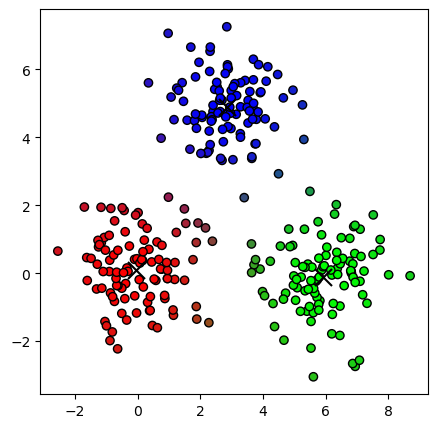

In [1]:
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt

def fcm(X, C, theta):  # FCM法
  n, m = X.shape  # データサイズの取得
  u = np.random.rand(C, n)  # クラスター割り当て初期化1
  u /= u.sum(axis=0)  # クラスター割り当て初期化2
  for step in range(100):  # メインのイテレーション
    u_old = u.copy()  # 更新前のクラスター割り当てを保持
    ut = u**theta  # クラスター中心算出1
    b = ut @ X / ut.sum(1)[:, np.newaxis]  # クラスター中心算出2
    d = dist.cdist(b, X)  # 距離行列算出
    u = d**(-2/(theta-1.0))  # メンバシップ値算出1
    u /= u.sum(axis=0)  # メンバシップ値算出2
    if np.abs(u - u_old).max() < 1e-5:  # 収束判定
      break
  return u, b  # クラスター割り当てとクラスター中心の返却

# 人工データセットの作成
np.random.seed(seed=0)
X = np.vstack((np.random.randn(100, 2)+(0, 0), 
               np.random.randn(100, 2)+(3, 5), 
               np.random.randn(100, 2)+(6, 0)))
n, m = X.shape

# FCM法の実行と結果の表示
C = 3
theta = 2.0
u, b = fcm(X, C, theta)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=u.T, edgecolors='k')
plt.scatter(b[:, 0], b[:, 1], marker='x', c='k', s=150)
plt.show()

# クラスタリングベースのCF
- 前回取り扱ったCFには様々なアプローチが存在するが，今回はクラスタリングベースのCFに着目してみよう．
- CFでは多数のユーザーのアイテム嗜好パターンに関するデータを取り扱う．
- クラスタリングによって，嗜好パターンの類似したユーザーからなるクラスターを抽出できる．
- 各ユーザーに対し，帰属するクラスター内で嗜好度の高いアイテムを推薦することで，クラスター毎の嗜好パターンを反映した推薦が可能となる．

## FCM法に基づくCF
- $n$ 人のユーザー，$m$ 個のアイテムからなる $n\times m$ のデータ行列 $X = [x_{ij}]$ を考える．
- $x_{ij}$ はユーザー $i$ がアイテム $j$ に与えた評価値である．
- 例えば，5段階評価 $x_{ij} \in \{1, 2, 3, 4, 5\}. $
- クラスター数 $C$ を設定し，ユーザーをFCM法でクラスタリングすると，結果として $u_{ci}$ と $\textbf{b}_{c}$ が得られる．
- ユーザー $i$ に対するアイテム $j$ の推薦度 $\hat{x}_{ij}$ を次式で求める．
\begin{eqnarray}
\hat{x}_{ij} = \sum_{c=1}^{C}u_{ci}b_{cj}
\end{eqnarray}
クラスター中心の各次元の値は当該クラスター内でのアイテムの嗜好度の大きさを表す．<br>
ユーザー $i$ の帰属するクラスター内でアイテム $j$ の嗜好度が高ければ，推薦度が大きくなる．<br>
ユーザー $i$ の各クラスターへの帰属度は総和1のファジィメンバシップであるため，各クラスターの加重平均となる．

### 注意点
- CFタスクにおけるデータは多数の**欠損値**(未評価値)を含むが，FCM法は欠損値を含むデータに適用できない．
- 今回は，欠損値を「全評価値の平均」に置き換えることで，欠損値補完をした上でFCM法を適用しよう．

# 準備：CF用のデータの取得
- 前回と同様にCF用のデータを取得する．
- MovieLens 100kデータセットのトレーニングデータとテストデータを取得．
- 詳細は前回の資料参照．

In [2]:
import os
import pandas as pd
import gdown
from sklearn.metrics import roc_curve, roc_auc_score

if not os.path.isfile('u.data'):
  url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
  gdown.download(url, 'u.data', quiet=False)

df = pd.read_table('u.data', names=('user_id', 'item_id', 'rating', 'timestamp'))
print(df)
X_df = df.pivot_table(index={'user_id'}, columns={'item_id'}, values='rating')
print(X_df)

if not os.path.isfile('u1.base'):
  url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u1.base'
  gdown.download(url, 'u1.base', quiet=False)
  url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u1.test'
  gdown.download(url, 'u1.test', quiet=False)

train_df = pd.read_table('u1.base', names=('user_id', 'item_id', 'rating', 'timestamp'))
X_train_df = train_df.pivot_table(index={'user_id'}, columns={'item_id'}, values='rating')
count = 0
for c in X_df.columns:
  try:
    X_train_df[c]
  except KeyError:
    count += 1
    X_train_df[c] = np.nan
X_train_df = X_train_df.sort_index(axis=1)
X_train = X_train_df.values
print('トレーニングデータの評価値行列 X_train')
print(X_train)

test_df = pd.read_table('u1.test', names=('user_id', 'item_id', 'rating', 'timestamp'))
print('テストデータ test_df')
print(test_df)

       user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5

# 課題用のコード
- 下記のコードでは，現状，推薦度行列 `X_rec` の要素に $\{1, 2, 3, 4, 5\}$ の乱数が入っており，適切な推薦度になっていない．
- したがって，推薦性能の指標であるROC-AUCの値は `0.5` 付近になっている．
- 前述のFCM法に基づくCFを実装し，推薦度行列 `X_rec` を適切に計算するように変更する．

## 作業
コード内の `### Start ###` と `### End ###` の間で，下記の処理行う．
1. データ行列 `X_train` の欠損値 `nan` を，「`X_train` 内に存在する全評価値の平均値」に置き換えた行列を `X_train_comp` とする．
2. 補完データ行列 `X_train_comp` に `C = 5`, `theta = 1.03` のFCM法(前述の `fcm` 関数)を適用し，メンバシップ行列 `u` とクラスター中心行列 `b` を取得する．
3. クラスタリング結果の `u` と `b` に基づいて推薦度の行列 `X_rec` を求める．

## Note
- テストデータにおける推薦性能の評価で，前回は各ユーザー `i`, 各アイテム `k` について逐一推薦度の計算を行っていたが，今回は先に推薦度行列 `X_rec` を一括で求め，その要素をfor文内で参照する方式をとっている．

## ヒント
- 欠損値を含む行列の平均 `np.nanmean`
- 欠損値の置き換え `np.nan_to_num`

「真の評価値」と「推定した評価値」
[[5.         3.52271495]
 [3.         3.57471528]
 [5.         3.92626293]
 ...
 [3.         3.48945684]
 [3.         3.55105309]
 [5.         3.50975205]]
ROC-AUCスコア：0.7376610283306019


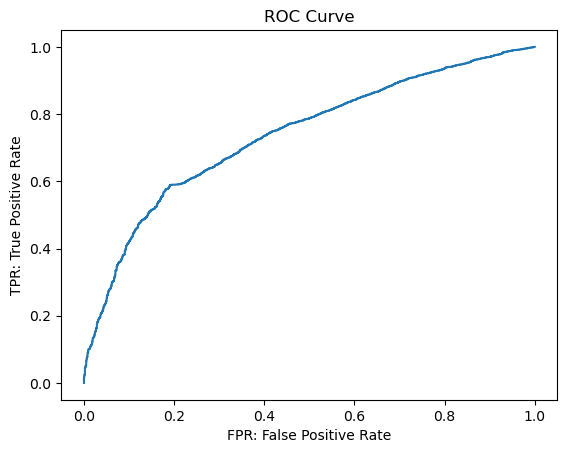

In [3]:
# トレーニングデータのサイズを取得
n, m = X_train.shape

### Start ###
# X_rec = np.random.choice([1, 2, 3, 4, 5], size=(n, m))

# データ行列 X_train の欠損値 nan を，「X_train 内に存在する全評価値の平均値」に置き換えた行列を X_train_comp とする．
X_train_comp = np.nan_to_num(X_train, nan=np.nanmean(X_train))
# 補完データ行列 X_train_comp に C = 5, theta = 1.03 のFCM法(前述の fcm 関数)を適用し，メンバシップ行列 u とクラスター中心行列 b を取得する．
u, b = fcm(X_train_comp, C=5, theta=1.03)
# クラスタリング結果の u と b に基づいて推薦度の行列 X_rec を求める．
X_rec = u.T @ b
### End ###

# テストデータにおける推薦性能の評価
result = []
for i, k, rate, time in test_df.values:
  # 以下でユーザー i に対するアイテム k の推薦度 y を参照する．※インデックスのずれに注意
  y = X_rec[i-1, k-1]
  # 「真の評価値」と「推定した評価値」を保存する．
  result.append([rate, y])

print('「真の評価値」と「推定した評価値」')
result = np.array(result)
print(result)

fpr, tpr, thresholds = roc_curve(result[:, 0] >= 2, result[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
print(f'ROC-AUCスコア：{roc_auc_score(result[:, 0] >= 2, result[:, 1])}')
plt.show()

# 課題
## 実行環境
Google Colaboratory を推奨．
## 要件
- 「課題用のコード」に基づいて，FCM法に基づく協調フィルタリングを実装する．
 - `C = 5`, `theta = 1.03` の場合のROC曲線を描画し，ROC-AUC値を算出する．

※注意：for文を使用せずに数式はNumPyを活用して実装すること．
***
## 提出について
- 下記の要件を満たす1つのWordファイルを提出する．
 - ファイル名「report12_XXXXX.docx」．ここで，XXXXXは各自の学籍番号．
 - 講義名，講義回，学籍番号，氏名，提出日を明示する．
 - 取り組んだ内容，ソースコード，コードの自作部分の解説，実行結果(グラフ含む)，結果の考察を記述する．
- 授業支援システムより提出．提出期限は授業支援システムを参照．